# October 28th #
### HW week 9 
### Review CH 6, Read CH 7A, work on term projects
### CH5 Review: Conclusions of Bayesian vs. Frequentist:
### -- Know both approaches and judge which tools appropriate for a given analysis
###  -- Optimization (~frequentist) much easier than integration (~Bayesian) in many -D so ML methods are typically frequentist

## Ch 6 Data Mining = Exploratory Data Analysis (EDA)
For N Point in D dimensions, 3 classic analyses



1) Density Estimation (infer PDF from sample)

2) Cluster finding (group finding)

3) Describe structure statistically (e.g., correlation functions)

### 6.1 Nonparametric density estimation : Kernel Density Estimation (KDE)

Ex: Figure 6.1 -- data (+) look bimodal, but histograms are bin dependent  . Middle left panel- turn each data point into a tophat instead of a delta func (tophat kernel)

Ideally we want smoother so we choose a gaussian kernel

6.1) $\hat{f}_n(x)=\frac{1}{Nh^D}\sum_{i=1}^NK\left(\frac{d(x,x_i)}{h}\right)$

$\hat{f_N}$ is the KDE for a local PDF

$D$ is the number of dims

$h $ bandwidth of the kernel

$ d$ distance from $x_i$ to $x$
K(U) must be continuous, non-negative. normalized over () and symmetric about $x_i$

3 kernels shown in 6.2

Fig 6.3 looks at SDSS Great Wall

### Minimum variance: Epanechnikov kernel 
6.9) $K(u)=3/4(1-u^2) |u|\leq 1$ and zero otherwise

saves computational cosd at large $d(x,x_i)$

Optimization of bandwidth in h:

1) Mean integrated square error (MISE)

2) or Likelihood cross-validation (similar to jackknife in that it removes values from Likelihood

### 6.1.2 KDE with measurement Errors: "Deconvolution KDE"

Three step procedure to deconvolve
1. Find $\hat{f}_n(x)$ and Fourier transform $\rightarrow F(k)$

2. From noise distribution $g(x)$ FT $\rightarrow G(K)$

3. From eq. 6.10 and the convolution theorem, the Fourier transform of the true distribution $h(x)$ is given by $H(k) = F (k)/G(k)$. The underlying noise-free pdf $h(x)$ can be computed via the inverse Fourier transform of $H(k)$.

Can derive the deconvolved kernel analytically for some simple noise distributions and apply directly. 

## 6.2 Nearest Neighbor Density Estimation

Find the distance to the $k_{th}$ nearest neighbor object, $d_k$, from every (grid) point x

$\hat{f}_k(x)=\frac{K}{V_D(d_k)}$

Where $V_D$ would be for example $4/3\pi d_k^3$

Should use $k\geq 5$ to reduce bias and variance

If computation is not a challenge, it's even better to use all nearest neighbors 

6.15)     $\hat{f}_k(x)=\frac{C}{\sum_{i=1}^k d_i^D}$

Fig 6.4 shows KDE and nearest neighbor DE for SDSS Great Wall

## 6.3 Parametric Density Estimation
e.g. Using a Mixture Model
Use fewer kernels, fit for parameterized locations and widths 

Ex. Figure 6.6 in the left panel

Ex. Figure 6.7 Great Wall 100 Kernels

Figure 6.10 cloning a 2-D distribution with Gaussian Mixture Models

### 6.3.2 Extreme Deconvolution (XD) - Apply GMM incorporating observational errors. 

Seek the GMM parameters (locations, widths and weights of components) that maximize the likelihood given known errors. 

Ex Figure 6.12 applies XD to single epoch SDSS data to recover the "truth"

## 6.4 Finding Clusters in Data
-unsupervised. So no prior information or training set. 

### K-means: partitions the data into k disjoint subsets labeled $C_k$ each containing $N_k$ points such that we minimize the quantity 
6.68) $\sum_{k=1}^K\sum_{i\in C_k}||x_i-\mu_k||^2$
where 


$\mu_k=1/N_k \sum_{i\in C_k}x_i$ is mean of points in set $C_k$

Procedure: Choose K, choose initial centroids $\mu_k$, assign each point to the cluster that it is closest to via nearest neighbor, update $\mu_k$ iterate till no changes. 

Figure 6.13 shows 

Figure 6.14 shows an alternate method which performs much better

### 6.4.5 Heirarchical Clustering
Avoid specifying K by finging all clusters at al scales. Start with Ndata clusters, merge nearest pair of clusters. Repeat

Ex: Minimum spanning tree, applied to SDSS Great Wall in fig 6.15 (plate 4 in color plates) Closely related to friends-of-friends 

## Hack
Reproduce Fig. 5.26; note if your MCMC parameter contours match precisely, and explain why or why not; now conduct a test for convergence

In [2]:
%matplotlib inline

In [8]:
%config InlineBackend.figure_format = 'retina'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, x0, A]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:06<00:00, 3710.58draws/s]


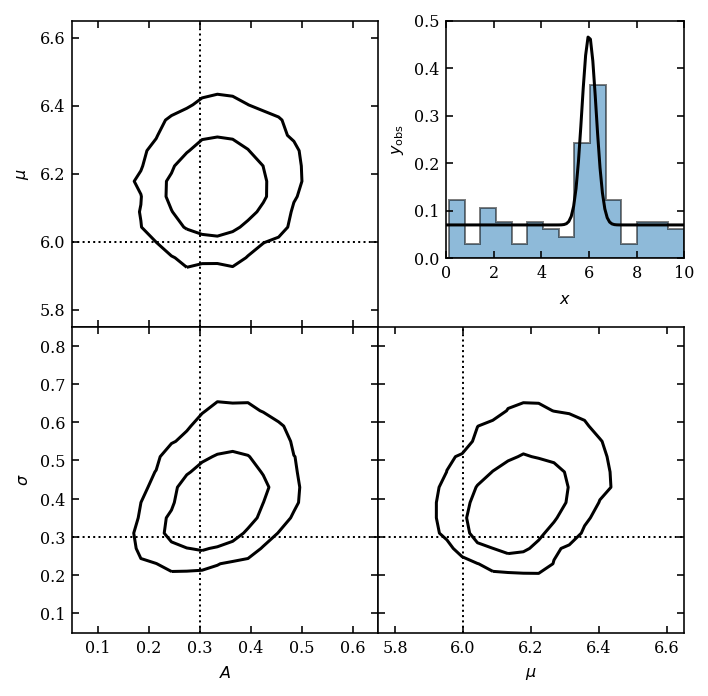

In [17]:
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

import pymc3 as pm
import theano.tensor as tt

from astroML.plotting import plot_mcmc

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

# ----------------------------------------------------------------------
# Set up dataset: gaussian signal in a uniform background
np.random.seed(0)

N = 100

A_true = 0.3
W_true = 10
x0_true = 6
sigma_true = 0.3

signal = stats.norm(x0_true, sigma_true)
background = stats.uniform(0, W_true)

x = np.random.random(N)
i_sig = x < A_true
i_bg = ~i_sig
x[i_sig] = signal.rvs(np.sum(i_sig))
x[i_bg] = background.rvs(np.sum(i_bg))


# ----------------------------------------------------------------------
# Set up MCMC sampling
with pm.Model():
    A = pm.Uniform('A', 0, 1)
    x0 = pm.Uniform('x0', 0, 10)
    log_sigma = pm.Uniform('log_sigma', -5, 5)

    def sigbg_like(x):
        """signal + background likelihood"""
        sigma = np.exp(log_sigma)
        return tt.sum(np.log(A * np.exp(-0.5 * ((x - x0) / sigma) ** 2)
                             / np.sqrt(2 * np.pi) / sigma + (1 - A) / W_true))

    SigBG = pm.DensityDist('sigbg',
                           logp=sigbg_like,
                           observed=x)
    trace = pm.sample(draws=5000, tune=1000)

# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
ax_list = plot_mcmc([trace[s] for s in ['A', 'x0']] + [np.exp(trace['log_sigma']),],
                    limits=[(0.05, 0.65), (5.75, 6.65), (0.05, 0.85)],
                    labels=[r'$A$', r'$\mu$', r'$\sigma$'],
                    bounds=(0.1, 0.1, 0.95, 0.95),
                    true_values=[A_true, x0_true, sigma_true],
                    fig=fig, colors='k')

ax = plt.axes([0.62, 0.62, 0.33, 0.33])
x_pdf = np.linspace(0, 10, 100)
y_pdf = A_true * signal.pdf(x_pdf) + (1 - A_true) * background.pdf(x_pdf)

ax.hist(x, 15, density=True, histtype='stepfilled', alpha=0.5)
ax.plot(x_pdf, y_pdf, '-k')

ax.set_xlim(0, 10)
ax.set_ylim(0, 0.5)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, x0, A]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:07<00:00, 3412.92draws/s]


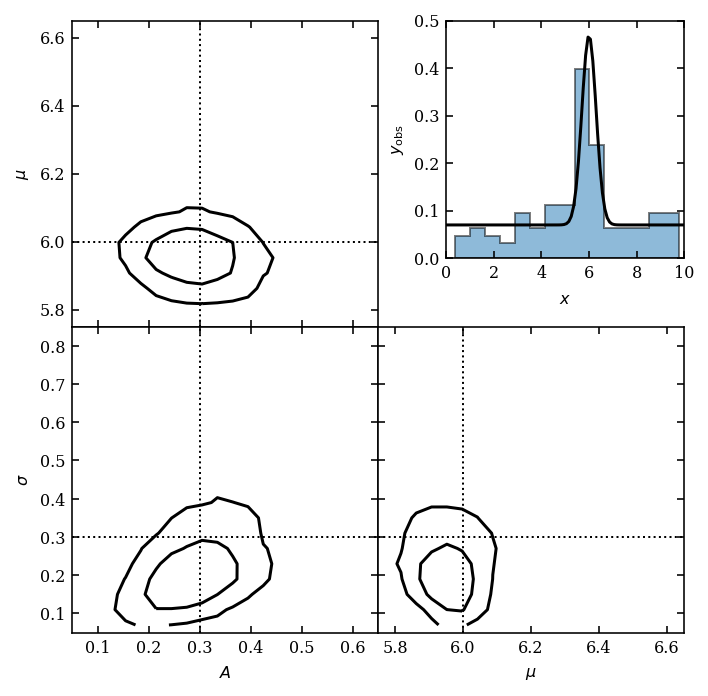

In [11]:
# Let's try with a different seed
np.random.seed(100)

N = 100

A_true = 0.3
W_true = 10
x0_true = 6
sigma_true = 0.3

signal = stats.norm(x0_true, sigma_true)
background = stats.uniform(0, W_true)

x = np.random.random(N)
i_sig = x < A_true
i_bg = ~i_sig
x[i_sig] = signal.rvs(np.sum(i_sig))
x[i_bg] = background.rvs(np.sum(i_bg))


# ----------------------------------------------------------------------
# Set up MCMC sampling
with pm.Model():
    A = pm.Uniform('A', 0, 1)
    x0 = pm.Uniform('x0', 0, 10)
    log_sigma = pm.Uniform('log_sigma', -5, 5)

    def sigbg_like(x):
        """signal + background likelihood"""
        sigma = np.exp(log_sigma)
        return tt.sum(np.log(A * np.exp(-0.5 * ((x - x0) / sigma) ** 2)
                             / np.sqrt(2 * np.pi) / sigma + (1 - A) / W_true))

    SigBG = pm.DensityDist('sigbg',
                           logp=sigbg_like,
                           observed=x)
    trace = pm.sample(draws=5000, tune=1000)

# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
ax_list = plot_mcmc([trace[s] for s in ['A', 'x0']] + [np.exp(trace['log_sigma']),],
                    limits=[(0.05, 0.65), (5.75, 6.65), (0.05, 0.85)],
                    labels=[r'$A$', r'$\mu$', r'$\sigma$'],
                    bounds=(0.1, 0.1, 0.95, 0.95),
                    true_values=[A_true, x0_true, sigma_true],
                    fig=fig, colors='k')

ax = plt.axes([0.62, 0.62, 0.33, 0.33])
x_pdf = np.linspace(0, 10, 100)
y_pdf = A_true * signal.pdf(x_pdf) + (1 - A_true) * background.pdf(x_pdf)

ax.hist(x, 15, density=True, histtype='stepfilled', alpha=0.5)
ax.plot(x_pdf, y_pdf, '-k')

ax.set_xlim(0, 10)
ax.set_ylim(0, 0.5)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

In [12]:
!pip install pymc

     |████████████████████████████████| 358kB 2.5MB/s eta 0:00:01
  Created wheel for pymc: filename=pymc-2.3.6-cp35-cp35m-macosx_10_6_x86_64.whl size=651718 sha256=cb9e16edcc49bf24ee5bae37a65c8cde0c57b891297da79b68b73628a9c61fa6
  Stored in directory: /Users/Charlotte/Library/Caches/pip/wheels/e4/6d/cf/3c408a39cf0f43e3b8abcace9758575f29c6aa860e17e9222d
Successfully built pymc
You should consider upgrading via the 'pip install --upgrade pip' command.


 [-----------------100%-----------------] 25000 of 25000 complete in 4.2 sec

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


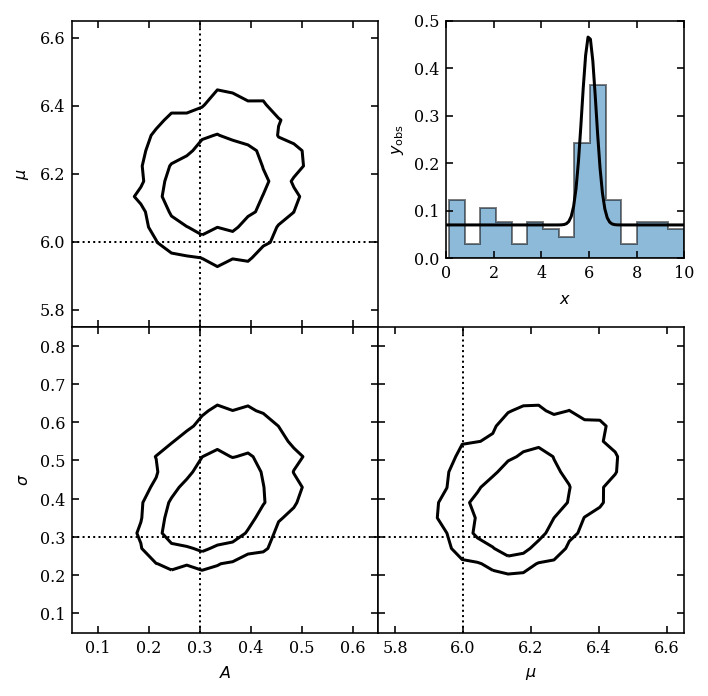

In [15]:
# version 1 plot
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting import plot_mcmc

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# Set up dataset: gaussian signal in a uniform background
np.random.seed(0)

N = 100

A_true = 0.3
W_true = 10
x0_true = 6
sigma_true = 0.3

signal = stats.norm(x0_true, sigma_true)
background = stats.uniform(0, W_true)

x = np.random.random(N)
i_sig = x < A_true
i_bg = ~i_sig
x[i_sig] = signal.rvs(np.sum(i_sig))
x[i_bg] = background.rvs(np.sum(i_bg))

#----------------------------------------------------------------------
# Set up MCMC sampling
A = pymc.Uniform('A', 0, 1, value=0.5)
x0 = pymc.Uniform('x0', 0, 10, value=5)
log_sigma = pymc.Uniform('log_sigma', -5, 5, value=0)


@pymc.deterministic
def sigma(log_sigma=log_sigma):
    return np.exp(log_sigma)


def sigbg_like(x, A, x0, sigma):
    """signal + background likelihood"""
    return np.sum(np.log(A * np.exp(-0.5 * ((x - x0) / sigma) ** 2)
                         / np.sqrt(2 * np.pi) / sigma
                         + (1 - A) / W_true))

SigBG = pymc.stochastic_from_dist('sigbg',
                                  logp=sigbg_like,
                                  dtype=np.float, mv=True)

M = SigBG('M', A, x0, sigma, observed=True, value=x)

model = dict(M=M, A=A, x0=x0, log_sigma=log_sigma, sigma=sigma)

#----------------------------------------------------------------------
# Run the MCMC sampling
S = pymc.MCMC(model)
S.sample(iter=25000, burn=5000)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
ax_list = plot_mcmc([S.trace(s)[:] for s in ['A', 'x0', 'sigma']],
                    limits=[(0.05, 0.65), (5.75, 6.65), (0.05, 0.85)],
                    labels=['$A$', '$\mu$', r'$\sigma$'],
                    bounds=(0.1, 0.1, 0.95, 0.95),
                    true_values=[A_true, x0_true, sigma_true],
                    fig=fig, colors='k')

ax = plt.axes([0.62, 0.62, 0.33, 0.33])
x_pdf = np.linspace(0, 10, 100)
y_pdf = A_true * signal.pdf(x_pdf) + (1 - A_true) * background.pdf(x_pdf)

ax.hist(x, 15, normed=True, histtype='stepfilled', alpha=0.5)
ax.plot(x_pdf, y_pdf, '-k')

ax.set_xlim(0, 10)
ax.set_ylim(0, 0.5)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

<MultiTrace: 4 chains, 5000 iterations, 6 variables>


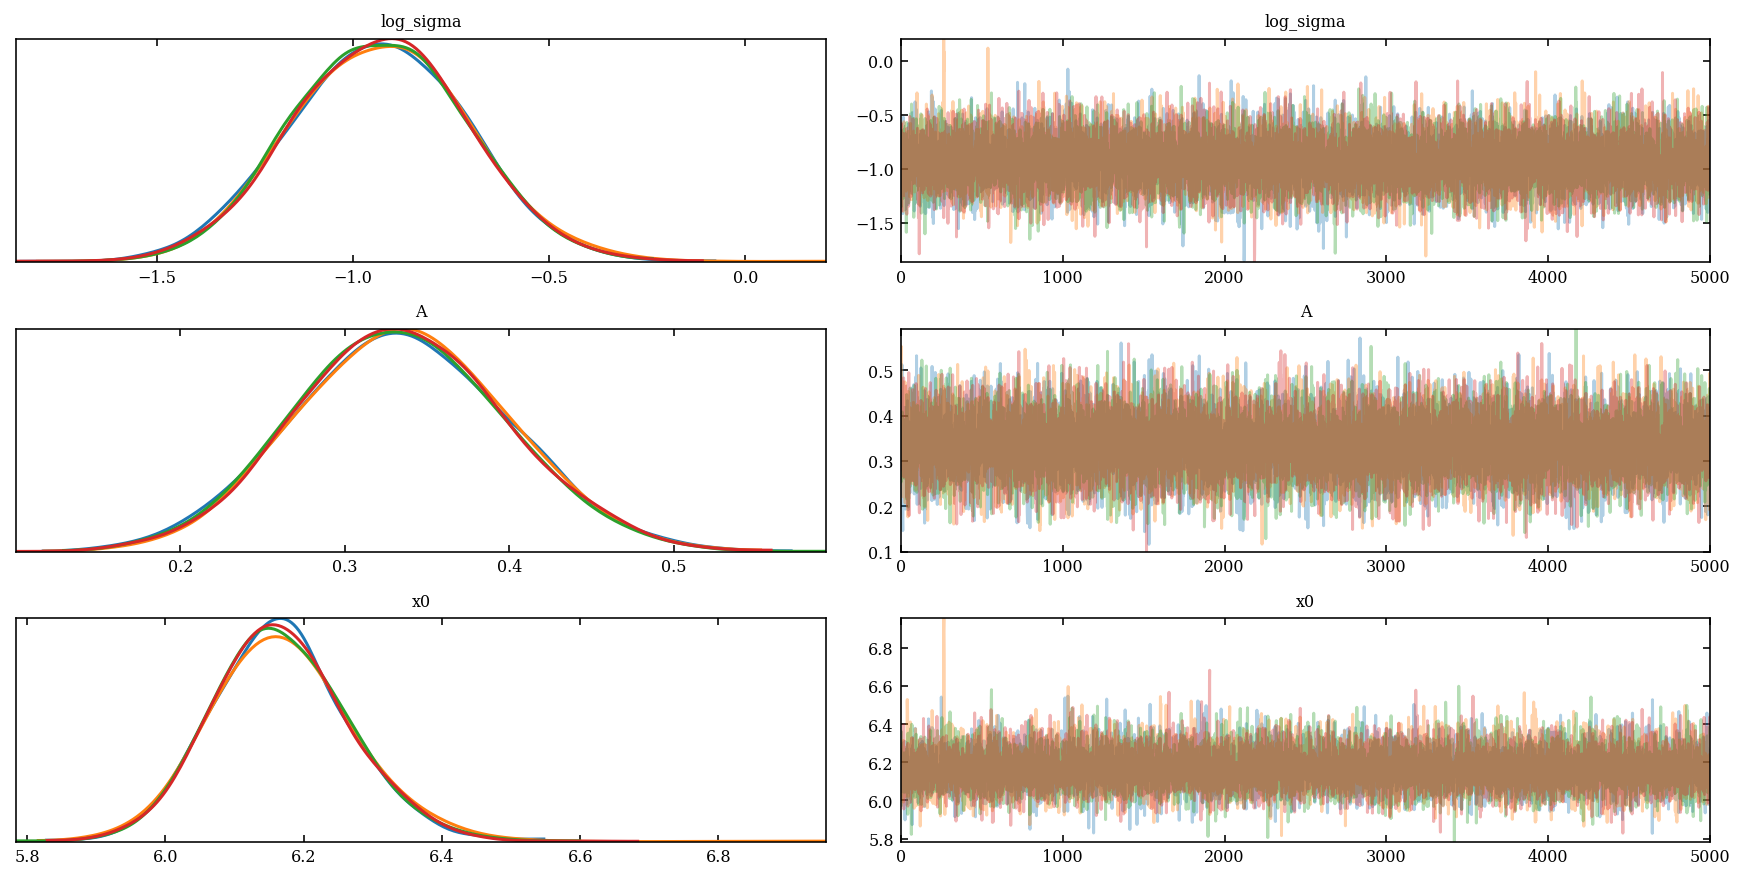

In [24]:


pm.plots.traceplot(trace);

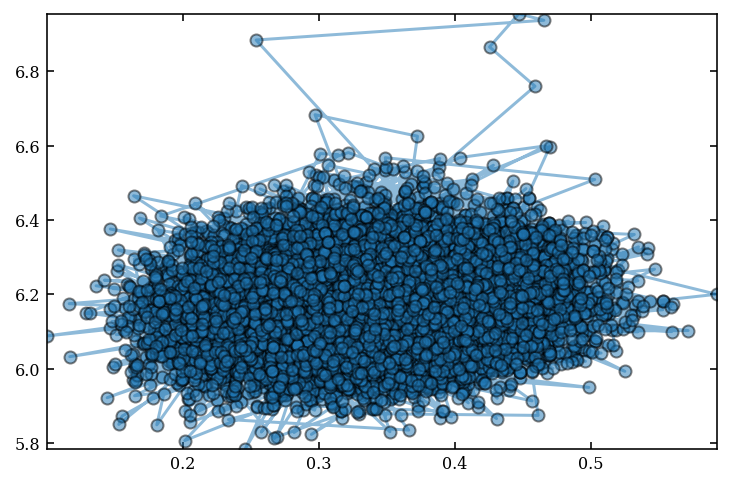

In [50]:
plt.plot(trace['A'],trace['x0'], '-o', alpha=0.5)

#plt.plot(trace['A'][-num:],trace['x0'][-num:], '-o', alpha=0.5)

(5.8, 6.9)

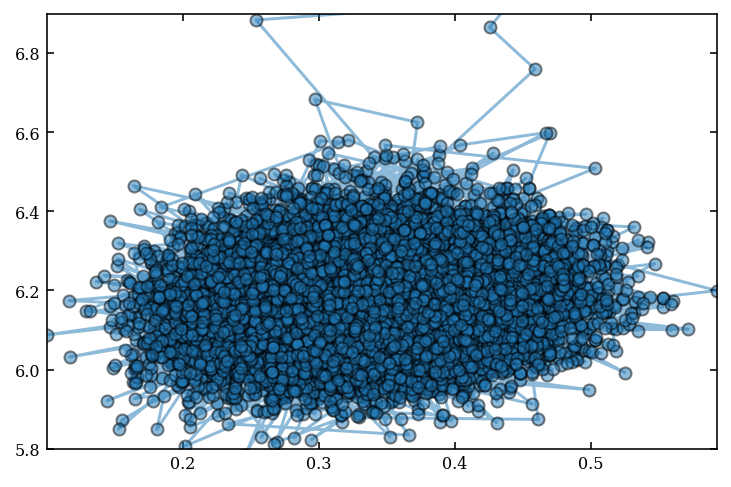

In [65]:
num = 25000
plt.plot(trace['A'][:num],trace['x0'][:num], '-o', alpha=0.5)
plt.ylim(5.8,6.9)

In [53]:
np.argmax(trace['x0'])

5266

In [48]:
len(trace['x0'])

20000